# IMPORT STATMENTS FOR ALL MODLES

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

2.1.0
2.2.4


Using TensorFlow backend.
/home/mgill/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
#Reads in data from the training testing data csv, and the holdout data csv
#extracts the final column to be the label set for both training testing and holdout
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [ ]:
#variables used going forward
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Oil_Merged_filtered.csv_train_test.csv_5pcnt.csv", "Oil_Merged_filtered.csv_holdout.csv_5pcnt.csv")

In [ ]:
#Fits a one hot encoder to the training set, then transforms the training set and holdout set
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
#saves the ohe for later use in case data needs to be encoded in same format
pickle.dump(ohe, open("Oil_ohe.dat", "wb"))

In [4]:
#if need or have new holdout data etc.
ohe = pickle.load(open("Oil_ohe.dat", "rb"))

In [5]:
#goes through each category stored in the encoder to find the specific value of feature
#works as category stores the value of each SNP linearly and features in XGBoost model are names f0 -> f99999 etc.
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [6]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

A/A


# XGBoost ML Model

In [1]:
#FOR OPTIMISING MODEL
#SKIP IF MODEL ALREADY OPTIMISED FOLLOWING IF ALREADY OPTIMISED
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

NameError: name 'tt_vcf' is not defined

In [ ]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}


In [ ]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [ ]:
xgbreg = xgb.XGBRegressor()
xgb_bayes_search = BayesSearchCV(xgbreg, space, n_iter=16, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

In [ ]:
#check to make sure all the data has remained the same
np.isnan(X_train).any()
np.isnan(y_train).any()

np.isinf(X_train).any()
np.isinf(y_train).any()

In [ ]:
xgb_bayes_search.best_params_

In [ ]:
##START HERE
#EITHER THE XGBOOST MODEL will defined with the best estimator function or typed in if not open in same session

#xgbreg = xgb_bayes_search.best_estimator_ #xgb.XGBRegressor(#n_estimators=100, nthread=-1) 
best_params = OrderedDict([('colsample_bylevel', 0.88542798001491),
             ('colsample_bytree', 0.15107725561517718),
             ('gamma', 0.09274068410384222),
             ('learning_rate', 0.11437510345794359),
             ('max_delta_step', 0),
             ('max_depth', 6),
             ('min_child_weight', 5),
             ('n_estimators', 200),
             ('reg_alpha', 1.2952579279714691e-08),
             ('reg_lambda', 0.45707493844512304),
             ('scale_pos_weight', 10.561837873121673),
             ('subsample', 0.9105119208713889)])
xgbreg = xgb.XGBRegressor(**best_params)

In [ ]:
print(xgbreg)

In [ ]:
#one function which should print out how the model performs
def eval_k_fold(m, x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = m
    i = 1
    for train,test in cv.split(x,y):
        #print(y[test])
        m.fit(x[train],y[train].ravel())
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [ ]:
best_model = eval_k_fold(xgbreg, tt_vcf, tt_pheno, 10)

In [ ]:
#uses best model from kfold eval on the holdoutset to predict how it went
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

In [ ]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("XGBoost Seed Oil Prediction")
plt.show()

In [ ]:
#save this model for later
pickle.dump(best_model, open("Oil_kfold_10_XGB.pickle.dat", "wb"))

In [7]:
#only load if not generated in same session
best_model = pickle.load(open("Oil_kfold_10_XGB.pickle.dat", "rb"))

In [ ]:
#what the model initially generates for feature importance with inbuilt functions

from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("Oil_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [8]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("Oil_Merged_filtered.csv_train_test.csv_5pcnt.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28591
(753, 28591)
my header list is: 28591
my X value is: 57454
(753, 28863)
my header list is: 57454
my X value is: 86547
(753, 29093)
my header list is: 86547
my X value is: 115738
(753, 29191)
my header list is: 115738
my X value is: 144631
(753, 28893)
my header list is: 144631
my X value is: 173880
(753, 29249)
my header list is: 173880
my X value is: 202979
(753, 29099)
my header list is: 202979
my X value is: 232057
(753, 29078)
my header list is: 232057
my X value is: 260926
(753, 28869)
my header list is: 260926
my X value is: 289773
(753, 28847)
my header list is: 289773
my X value is: 318745
(753, 28972)
my header list is: 318745
my X value is: 347724
(753, 28979)
my header list is: 347724
my X value is: 377090
(753, 29366)
my header list is: 377090
my X value is: 406042
(753, 28952)
my header list is: 406042
my X value is: 435460
(753, 29418)
my header list is: 435460
my X value is: 464590
(753, 29130)
my header list is: 464590
my X value is: 493708
(753, 29

In [ ]:
##IGNORE THIS WAS OLD WORK IN WHICH THE SCORES HAD TO BE MANUALLY ENTERED

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [593927,29855,588433,594046,588431,154384,89664,238306,29856,133635,212368,97360,310115,214640,238315]
scores = [3788.51,3012.53,2338.82,1817.61,1267.10,956.13,721.52,464.87,423.59,387.93,344.70,308.57,249.15,241.69,225.54]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [9]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [10]:
#renaming headers to be cleaner and have the appropriate allele
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [11]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893


In [12]:
#put into dataframe
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm20_8078669 (A/A)     3788.515620
Gm08_9166228 (G/G)      241.692505
Gm07_45821320 (A/A)     149.644531
Gm16_32413893 (A/A)      79.890625
Gm03_32211971 (G/G)      16.695312
                          ...     
Gm19_2899158 (C/C)        0.097059
Gm03_8415236 (C/C)        0.048430
Gm15_47314687 (C/C)       0.050762
Gm20_41787717 (A/A)       0.072517
Gm13_30712121 (G/G)       0.094101
Length: 1893, dtype: float64
                     F_Score(GAIN)
Gm20_8078669 (A/A)     3788.515620
Gm08_9166228 (G/G)      241.692505
Gm07_45821320 (A/A)     149.644531
Gm16_32413893 (A/A)      79.890625
Gm03_32211971 (G/G)      16.695312
...                            ...
Gm19_2899158 (C/C)        0.097059
Gm03_8415236 (C/C)        0.048430
Gm15_47314687 (C/C)       0.050762
Gm20_41787717 (A/A)       0.072517
Gm13_30712121 (G/G)       0.094101

[1893 rows x 1 columns]


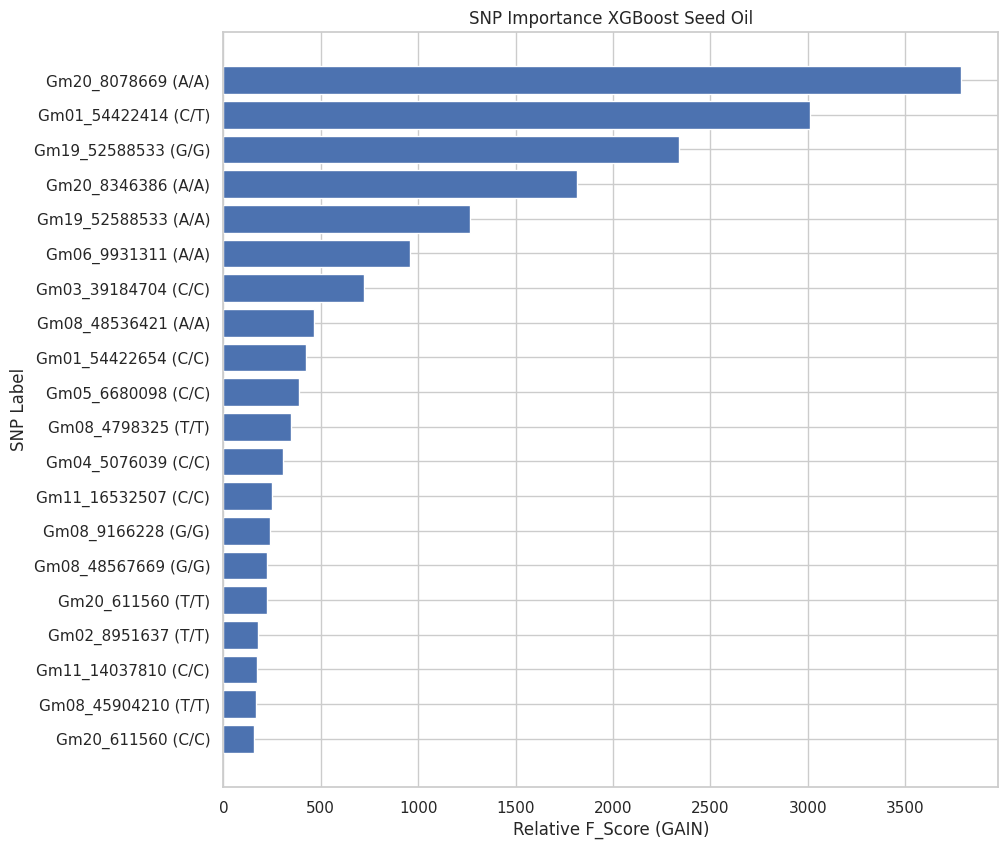

In [13]:
#plot dataframe now with top 20 SNPS
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

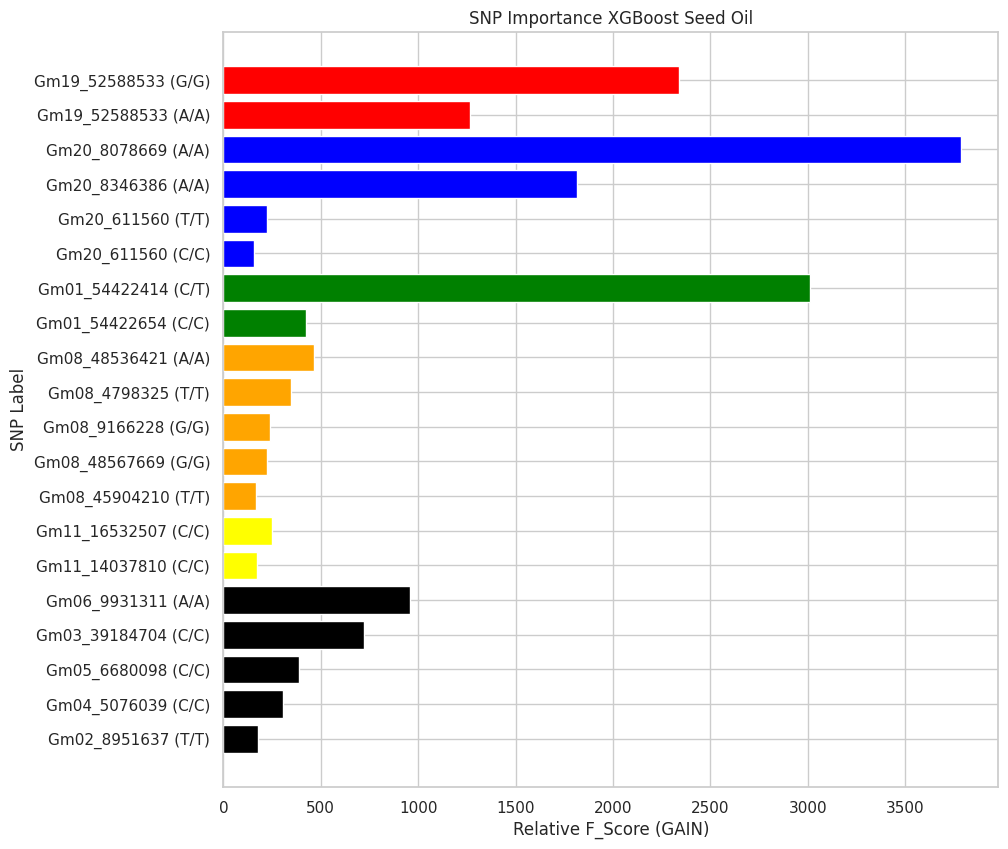

In [16]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm19' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm20' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm01' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm11' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm08' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(b_i, b_v, color="blue")
plt.barh(r_i, r_v, color="red")
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest Model

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Oil_Merged_filtered.csv_train_test.csv_5pcnt.csv", "Oil_Merged_filtered.csv_holdout.csv_5pcnt.csv")

In [ ]:
ohe = pickle.load(open("Oil_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=16, max_features = 'sqrt',n_jobs=-1, verbose = 1)
#trains the model, and makes the y shape as (m,) instead of (m,1)
#model.fit(X_train, y_train.ravel())

In [ ]:
best_rf_model = eval_k_fold(model, tt_vcf, tt_pheno, 10)

In [ ]:
all_preds = [x for x in best_rf_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

In [ ]:
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, y_pred[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

# CNN Model (Based upon DL Primer & GMStools)

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Oil_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'Oil_Merged_filtered.csv_holdout.csv_5pcnt.csv')

In [ ]:
ohe = pickle.load(open("Oil_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
def build_CNN_model(train_size):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(train_size, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='mean_squared_error', optimizer=opt, 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    print(model.summary())
    return model

In [ ]:
def eval_CNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_CNN_model(x.shape[1])
        print("Fold:" + str(i))
        x = x.reshape(x.shape[0], x.shape[1], 1)
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=50, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [ ]:
#my_model = build_CNN_model()
best_model = eval_CNN(tt_vcf, tt_pheno, 10)

In [ ]:
pickle.dump(best_model, open("Oil_kfold_10_CNN.pickle.dat", "wb"))

In [ ]:
best_CNN = pickle.load(open("Oil_kfold_10_CNN.pickle.dat", "rb"))

In [ ]:
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

In [ ]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()
print(np.isinf(ho_pheno).any())
print(np.isinf(all_preds).any())
for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("XGBoost Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
all_preds = [x[0] for x in model.predict(X_test)]
sqrt(mean_squared_error(all_preds, y_test))
r2_score(all_preds, y_test)
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

# DNN model
#### Model Based upon: Crop Yield Prediction Using Deep Neural Networks(2019)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Oil_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'Oil_Merged_filtered.csv_holdout.csv_5pcnt.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(753,)
(753, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(189,)
(189, 1)
220000
(753, 213713)
(189, 213713)


In [5]:
ohe = pickle.load(open("Oil_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 620940)
(189, 213713)
(189, 620940)


In [6]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(200, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(model.summary())
    return model




In [7]:
def eval_DNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_DNN_model(x.shape[1])
        print("Fold:" + str(i))
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=50, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [8]:
#my_model = build_CNN_model()
best_DNN = eval_DNN(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               124188200 
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6

677/677 [==============================] - 2s 4ms/sample - loss: 2.7740 - root_mean_squared_error: 1.6655 - val_loss: 2.2778 - val_root_mean_squared_error: 1.5092
Epoch 35/50
677/677 [==============================] - 2s 4ms/sample - loss: 2.6155 - root_mean_squared_error: 1.6173 - val_loss: 2.2834 - val_root_mean_squared_error: 1.5111
Epoch 36/50
677/677 [==============================] - 2s 4ms/sample - loss: 2.6853 - root_mean_squared_error: 1.6387 - val_loss: 2.0968 - val_root_mean_squared_error: 1.4480
Epoch 37/50
677/677 [==============================] - 2s 4ms/sample - loss: 2.7986 - root_mean_squared_error: 1.6729 - val_loss: 2.5167 - val_root_mean_squared_error: 1.5864
Epoch 38/50
677/677 [==============================] - 2s 4ms/sample - loss: 2.4670 - root_mean_squared_error: 1.5707 - val_loss: 2.3658 - val_root_mean_squared_error: 1.5381
Epoch 39/50
677/677 [==============================] - 2s 4ms/sample - loss: 2.4937 - root_mean_squared_error: 1.5791 - val_loss: 2.4488 

Epoch 16/50
677/677 [==============================] - 2s 4ms/sample - loss: 4.0312 - root_mean_squared_error: 2.0078 - val_loss: 3.9718 - val_root_mean_squared_error: 1.9929
Epoch 17/50
677/677 [==============================] - 2s 4ms/sample - loss: 4.1342 - root_mean_squared_error: 2.0333 - val_loss: 3.9362 - val_root_mean_squared_error: 1.9840
Epoch 18/50
677/677 [==============================] - 2s 4ms/sample - loss: 4.1380 - root_mean_squared_error: 2.0342 - val_loss: 4.8901 - val_root_mean_squared_error: 2.2113
Epoch 19/50
677/677 [==============================] - 2s 4ms/sample - loss: 3.6570 - root_mean_squared_error: 1.9123 - val_loss: 3.4819 - val_root_mean_squared_error: 1.8660
Epoch 20/50
677/677 [==============================] - 2s 4ms/sample - loss: 3.7674 - root_mean_squared_error: 1.9410 - val_loss: 3.4550 - val_root_mean_squared_error: 1.8588
Epoch 21/50
677/677 [==============================] - 2s 4ms/sample - loss: 3.5733 - root_mean_squared_error: 1.8903 - val_l

Train on 677 samples, validate on 76 samples
Epoch 1/50
677/677 [==============================] - 18s 27ms/sample - loss: 242.7709 - root_mean_squared_error: 15.5811 - val_loss: 28.1638 - val_root_mean_squared_error: 5.3070
Epoch 2/50
677/677 [==============================] - 4s 6ms/sample - loss: 98.3711 - root_mean_squared_error: 9.9182 - val_loss: 217.4819 - val_root_mean_squared_error: 14.7473
Epoch 3/50
677/677 [==============================] - 2s 4ms/sample - loss: 21.7095 - root_mean_squared_error: 4.6593 - val_loss: 103.8996 - val_root_mean_squared_error: 10.1931
Epoch 4/50
677/677 [==============================] - 2s 4ms/sample - loss: 12.5126 - root_mean_squared_error: 3.5373 - val_loss: 30.1841 - val_root_mean_squared_error: 5.4940
Epoch 5/50
677/677 [==============================] - 2s 4ms/sample - loss: 11.8035 - root_mean_squared_error: 3.4356 - val_loss: 11.5277 - val_root_mean_squared_error: 3.3952
Epoch 6/50
677/677 [==============================] - 2s 4ms/sample

Epoch 29/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.8805 - root_mean_squared_error: 1.6972 - val_loss: 3.6245 - val_root_mean_squared_error: 1.9038
Epoch 30/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.9736 - root_mean_squared_error: 1.7244 - val_loss: 3.8053 - val_root_mean_squared_error: 1.9507
Epoch 31/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.4277 - root_mean_squared_error: 1.8514 - val_loss: 6.7148 - val_root_mean_squared_error: 2.5913
Epoch 32/50
678/678 [==============================] - 3s 4ms/sample - loss: 2.3570 - root_mean_squared_error: 1.5353 - val_loss: 3.4293 - val_root_mean_squared_error: 1.8518
Epoch 33/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.5378 - root_mean_squared_error: 1.5931 - val_loss: 3.6220 - val_root_mean_squared_error: 1.9032
Epoch 34/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.9523 - root_mean_squared_error: 1.7182 - val_l

Epoch 11/50
678/678 [==============================] - 2s 4ms/sample - loss: 6.8675 - root_mean_squared_error: 2.6206 - val_loss: 3.1410 - val_root_mean_squared_error: 1.7723
Epoch 12/50
678/678 [==============================] - 2s 4ms/sample - loss: 4.8636 - root_mean_squared_error: 2.2054 - val_loss: 5.0890 - val_root_mean_squared_error: 2.2559
Epoch 13/50
678/678 [==============================] - 2s 4ms/sample - loss: 5.5701 - root_mean_squared_error: 2.3601 - val_loss: 5.0951 - val_root_mean_squared_error: 2.2572
Epoch 14/50
678/678 [==============================] - 2s 4ms/sample - loss: 4.9471 - root_mean_squared_error: 2.2242 - val_loss: 2.9930 - val_root_mean_squared_error: 1.7300
Epoch 15/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.8427 - root_mean_squared_error: 1.9603 - val_loss: 3.1979 - val_root_mean_squared_error: 1.7883
Epoch 16/50
678/678 [==============================] - 3s 4ms/sample - loss: 4.1891 - root_mean_squared_error: 2.0467 - val_l

Train on 678 samples, validate on 75 samples
Epoch 1/50
678/678 [==============================] - 11s 17ms/sample - loss: 242.0163 - root_mean_squared_error: 15.5569 - val_loss: 818.0554 - val_root_mean_squared_error: 28.6017
Epoch 2/50
678/678 [==============================] - 3s 5ms/sample - loss: 102.5533 - root_mean_squared_error: 10.1269 - val_loss: 640.4510 - val_root_mean_squared_error: 25.3071
Epoch 3/50
678/678 [==============================] - 2s 4ms/sample - loss: 31.2322 - root_mean_squared_error: 5.5886 - val_loss: 169.4731 - val_root_mean_squared_error: 13.0182
Epoch 4/50
678/678 [==============================] - 2s 4ms/sample - loss: 19.0757 - root_mean_squared_error: 4.3676 - val_loss: 10.4904 - val_root_mean_squared_error: 3.2389
Epoch 5/50
678/678 [==============================] - 2s 4ms/sample - loss: 12.4396 - root_mean_squared_error: 3.5270 - val_loss: 7.4874 - val_root_mean_squared_error: 2.7363
Epoch 6/50
678/678 [==============================] - 3s 4ms/sam

Epoch 29/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.9452 - root_mean_squared_error: 1.9862 - val_loss: 9.3837 - val_root_mean_squared_error: 3.0633
Epoch 30/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.8755 - root_mean_squared_error: 1.6957 - val_loss: 5.2040 - val_root_mean_squared_error: 2.2812
Epoch 31/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.8661 - root_mean_squared_error: 1.6930 - val_loss: 3.2057 - val_root_mean_squared_error: 1.7905
Epoch 32/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.8016 - root_mean_squared_error: 1.6738 - val_loss: 3.6113 - val_root_mean_squared_error: 1.9003
Epoch 33/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.0415 - root_mean_squared_error: 1.7440 - val_loss: 3.9331 - val_root_mean_squared_error: 1.9832
Epoch 34/50
678/678 [==============================] - 3s 4ms/sample - loss: 2.0604 - root_mean_squared_error: 1.4354 - val_l

Epoch 11/50
678/678 [==============================] - 2s 4ms/sample - loss: 5.6001 - root_mean_squared_error: 2.3664 - val_loss: 3.7941 - val_root_mean_squared_error: 1.9479
Epoch 12/50
678/678 [==============================] - 2s 4ms/sample - loss: 5.2884 - root_mean_squared_error: 2.2997 - val_loss: 3.4308 - val_root_mean_squared_error: 1.8523
Epoch 13/50
678/678 [==============================] - 2s 4ms/sample - loss: 5.2793 - root_mean_squared_error: 2.2977 - val_loss: 3.1883 - val_root_mean_squared_error: 1.7856
Epoch 14/50
678/678 [==============================] - 2s 4ms/sample - loss: 5.0959 - root_mean_squared_error: 2.2574 - val_loss: 3.3802 - val_root_mean_squared_error: 1.8385
Epoch 15/50
678/678 [==============================] - 2s 4ms/sample - loss: 4.5344 - root_mean_squared_error: 2.1294 - val_loss: 3.4224 - val_root_mean_squared_error: 1.8500
Epoch 16/50
678/678 [==============================] - 2s 4ms/sample - loss: 4.4332 - root_mean_squared_error: 2.1055 - val_l

Train on 678 samples, validate on 75 samples
Epoch 1/50
678/678 [==============================] - 16s 24ms/sample - loss: 256.6408 - root_mean_squared_error: 16.0200 - val_loss: 93.5879 - val_root_mean_squared_error: 9.6741
Epoch 2/50
678/678 [==============================] - 3s 5ms/sample - loss: 118.9338 - root_mean_squared_error: 10.9057 - val_loss: 121.0670 - val_root_mean_squared_error: 11.0030
Epoch 3/50
678/678 [==============================] - 2s 4ms/sample - loss: 31.5218 - root_mean_squared_error: 5.6144 - val_loss: 49.3055 - val_root_mean_squared_error: 7.0218
Epoch 4/50
678/678 [==============================] - 2s 4ms/sample - loss: 18.6057 - root_mean_squared_error: 4.3134 - val_loss: 31.2479 - val_root_mean_squared_error: 5.5900
Epoch 5/50
678/678 [==============================] - 2s 4ms/sample - loss: 15.4611 - root_mean_squared_error: 3.9321 - val_loss: 18.4963 - val_root_mean_squared_error: 4.3007
Epoch 6/50
678/678 [==============================] - 2s 4ms/sample

Epoch 29/50
678/678 [==============================] - 3s 4ms/sample - loss: 2.4791 - root_mean_squared_error: 1.5745 - val_loss: 3.3698 - val_root_mean_squared_error: 1.8357
Epoch 30/50
678/678 [==============================] - 3s 4ms/sample - loss: 2.6215 - root_mean_squared_error: 1.6191 - val_loss: 3.0581 - val_root_mean_squared_error: 1.7488
Epoch 31/50
678/678 [==============================] - 2s 4ms/sample - loss: 2.6986 - root_mean_squared_error: 1.6428 - val_loss: 6.7460 - val_root_mean_squared_error: 2.5973
Epoch 32/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.1081 - root_mean_squared_error: 1.7630 - val_loss: 10.3125 - val_root_mean_squared_error: 3.2113
Epoch 33/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.3756 - root_mean_squared_error: 1.8373 - val_loss: 7.8648 - val_root_mean_squared_error: 2.8044
Epoch 34/50
678/678 [==============================] - 2s 4ms/sample - loss: 3.1911 - root_mean_squared_error: 1.7864 - val_

In [9]:
#ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_DNN.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.63
RMSE of Holdout: 1.84
Mean of Holdout: 17.17
this is 10.738319474063003% of the mean pheno data


0 17.6 [16.134573]
1 23.6 [19.051014]
2 15.1 [15.280489]
3 19.2 [18.973824]
4 14.5 [16.545984]
5 14.9 [14.623625]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

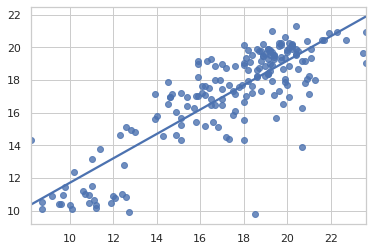

In [11]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("DNN Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()

In [ ]:
pickle.dump(best_DNN, open("Oil_kfold_10_DNN.pickle.dat", "wb"))

In [ ]:
best_DNN = pickle.load(open("Oil_kfold_10_DNN.pickle.dat", "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

range(0, 189)


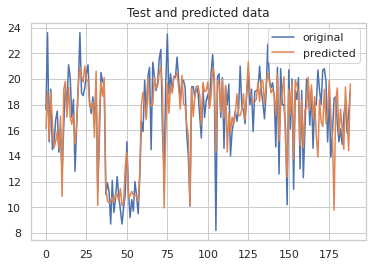

TypeError: list indices must be integers or slices, not range

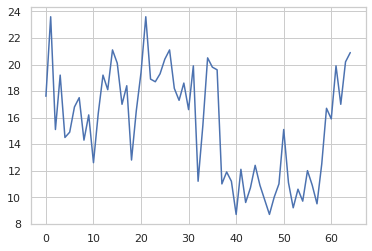

In [10]:
y_test=ho_pheno
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

In [ ]:
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

In [ ]:
ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")